In [2]:
import numpy as np
import pandas as pd
import keras.backend as K

from keras.models import Model, Sequential
from keras import models, layers, optimizers, regularizers
from keras.layers import Dense, Dropout, Input
from keras.optimizers import SGD
from keras.initializers import RandomNormal
from keras.utils.np_utils import to_categorical
from keras.engine.topology import Layer, InputSpec
from keras.callbacks import LearningRateScheduler


from sklearn.utils import shuffle
from sklearn.utils.linear_assignment_ import linear_assignment
from sklearn.metrics import confusion_matrix
import keras
import matplotlib.pyplot as plt
from keras import layers
from keras import backend as K

/home/dougwoodward/CADS/thesis/env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
kepler_data = pd.read_csv("kepler_data_full.csv", header=159)
kepler_data

,rowid,kepid,tce_plnt_num,tce_rogue_flag,tce_delivname,rowupdate,tce_datalink_dvs,tce_datalink_dvr,tce_period,tce_period_err,...,tce_dicco_mdec,tce_dicco_mdec_err,tce_dicco_msky,tce_dicco_msky_err,tce_dikco_mra,tce_dikco_mra_err,tce_dikco_mdec,tce_dikco_mdec_err,tce_dikco_msky,tce_dikco_msky_err
0,1,1162345,2,NaN,q1_q17_dr24_tce,2015-01-15,001/001162/001162345/dv/kplr001162345-002-2014...,001/001162/001162345/dv/kplr001162345-20141002...,0.831850,6.693070e-05,...,0.504060,1.2900,0.507070,1.1200,-0.183490,1.2100,0.424890,1.3000,0.462820,1.1000
1,2,1292087,2,NaN,q1_q17_dr24_tce,2015-01-15,001/001292/001292087/dv/kplr001292087-002-2014...,001/001292/001292087/dv/kplr001292087-20141002...,1.095240,1.009340e-05,...,-0.075798,0.2120,0.097899,0.2090,0.206520,0.2250,-0.077214,0.2380,0.220490,0.2200
2,3,1293031,2,NaN,q1_q17_dr24_tce,2015-01-15,001/001293/001293031/dv/kplr001293031-002-2014...,001/001293/001293031/dv/kplr001293031-20141002...,0.719273,1.388330e-05,...,0.337380,0.2890,0.444500,0.2240,-0.308090,0.1910,0.283570,0.2240,0.418720,0.2070
3,4,1162345,3,NaN,q1_q17_dr24_tce,2015-01-15,001/001162/001162345/dv/kplr001162345-003-2014...,001/001162/001162345/dv/kplr001162345-20141002...,0.831833,9.431020e-06,...,0.167200,0.1830,0.253410,0.1970,0.087066,0.2510,0.106320,0.1720,0.137420,0.1960
4,5,1164109,1,NaN,q1_q17_dr24_tce,2015-01-15,001/001164/001164109/dv/kplr001164109-001-2014...,001/001164/001164109/dv/kplr001164109-20141002...,622.408000,8.547390e-03,...,10.358000,0.0894,15.177000,0.0893,-11.060000,0.0892,10.437000,0.0894,15.207000,0.0893
5,6,757450,1,NaN,q1_q17_dr24_tce,2015-01-15,000/000757/000757450/dv/kplr000757450-001-2014...,000/000757/000757450/dv/kplr000757450-20141002...,8.884920,1.186150e-06,...,0.072221,0.0697,0.072362,0.0694,0.069581,0.0719,-0.103820,0.0782,0.124980,0.0763
6,7,892667,1,NaN,q1_q17_dr24_tce,2015-01-15,000/000892/000892667/dv/kplr000892667-001-2014...,000/000892/000892667/dv/kplr000892667-20141002...,2.262110,2.726600e-05,...,0.303870,0.1920,0.411080,0.1370,0.139510,0.0883,0.115410,0.1630,0.181060,0.1240
7,8,892772,1,NaN,q1_q17_dr24_tce,2015-01-15,000/000892/000892772/dv/kplr000892772-001-2014...,000/000892/000892772/dv/kplr000892772-20141002...,5.092600,3.144550e-05,...,-1.296300,0.1230,4.920200,0.1610,-4.962200,0.1580,-1.555100,0.1170,5.200200,0.1650
8,9,1026032,1,NaN,q1_q17_dr24_tce,2015-01-15,001/001026/001026032/dv/kplr001026032-001-2014...,001/001026/001026032/dv/kplr001026032-20141002...,8.460440,3.822250e-07,...,0.051352,0.0669,0.078983,0.0673,-0.004233,0.0737,-0.064448,0.0770,0.064587,0.0770
9,10,1026032,2,NaN,q1_q17_dr24_tce,2015-01-15,001/001026/001026032/dv/kplr001026032-002-2014...,001/001026/001026032/dv/kplr001026032-20141002...,4.230220,7.327150e-07,...,-0.003027,0.0678,0.051184,0.0676,-0.014758,0.0716,-0.137870,0.0841,0.138650,0.0840


In [4]:
k_data = kepler_data.copy()
k_data = k_data.drop(['rowid','kepid','tce_rogue_flag', 'tce_delivname', 'rowupdate', 
                           'tce_datalink_dvs', 'tce_datalink_dvr', 'tce_steff_prov', 
                           'tce_slogg_prov', 'tce_smet_prov','tce_sradius_prov', 'tce_limbdark_mod',
                           'tce_trans_mod', 'tce_eccen', 'tce_eccen_err', 'tce_longp', 'tce_longp_err'
                          ],axis=1)
# drop some columns that we will not be using
# starting with all NA columns
k_data.dropna(axis=1,how='any', inplace=True)

# drop all autovetter columns execpt the training set - as those are manually set - take as "truth"

k_data = k_data.drop(['av_vf_pc', 'av_vf_pc_err', 'av_vf_afp','av_vf_afp_err',
                           'av_vf_ntp', 'av_vf_ntp_err', 'av_pp_pc','av_pp_afp', 
                           'av_pp_ntp', 'tce_plnt_num'],axis=1)

# update to be categorical
#k_data = pd.get_dummies(k_data, columns=['av_training_set','av_pred_class'])

# train/test split
test = k_data.loc[k_data['av_training_set'] == "UNK"] # test data is all data labeled as UNK in av_training

y_test = test[['av_pred_class']]
y_test = pd.get_dummies(y_test)
x_test = test.drop(['av_training_set', 'av_pred_class'], axis=1)

train = k_data[k_data.av_training_set != "UNK"] # training data is all data that is AFP/NTP/PC

# the training labels are truth
y_train = train[['av_training_set']]
y_train = pd.get_dummies(y_train)
# we cluster without labels, then we augment data w/ cluster
x_train = train.drop(['av_training_set','av_pred_class'], axis=1)
#x_train = pd.get_dummies(x_train, columns=['av_training_set'])

x_test = test.av_pred_class
x_test = test.drop(['av_training_set','av_pred_class'], axis=1)



train_val_split_size = 1000

x_val = x_train[:train_val_split_size]
y_val = y_train[:train_val_split_size]
x_train = x_train[train_val_split_size:]
y_train = y_train[train_val_split_size:]

x_val = (x_val - x_train.mean()) / (x_train.max() - x_train.min())
x_train = (x_train - x_train.mean()) / (x_train.max() - x_train.min())

In [5]:
# ok - so we have a basic autoencoder
# but we did not do layerwise greedy pre training
# so we need to do that layerwise greedy pretrain
layer_sizes = [x_train.shape[1],500,500,2000,10]

# creates the layers to greedy layerwise pretrain
# takes par
def create_layers(layer_sizes):
    autoencoders = []
    encoders = []
    decoders = []
    for i in range(1, len(layer_sizes)):
        if i == len(layer_sizes) - 1:
            act = 'linear'
        else:
            act = 'relu'
        h = Dense(layer_sizes[i], activation=act,
                  input_shape=(layer_sizes[i-1],),
                  name='encoder_%d'%i,
                  bias_initializer='zeros',
                  kernel_initializer=RandomNormal(mean=0.0, stddev=0.01, seed=None))
        encoders.append(h)
        
        rev_i = len(layer_sizes) - i
        if i == 1:
            act = 'linear'
        else:
            act = 'relu'
        d = Dense(layer_sizes[i-1], activation=act,
                 name='decoder_%d'%rev_i,
                 bias_initializer='zeros',
                 kernel_initializer=RandomNormal(mean=0.0, stddev=0.01, seed=None))
        decoders.append(d)
        autoencoder = Sequential([
            Dropout(0.2, input_shape=(layer_sizes[i-1],),name='encoder_dropout_%d'%i),
            h,
            Dropout(0.2, name='decoder_dropout_%d'%rev_i),
            d
        ])
        autoencoder.compile(loss='mse', optimizer=SGD(lr=0.01, decay=0, momentum=0.9))
        autoencoders.append(autoencoder)
    return autoencoders, encoders, decoders

# build up some models
autoencoders, encoders, decoders = create_layers(layer_sizes)

encoder = Sequential(encoders)
encoder.compile(loss='mse', optimizer=SGD(lr=0.1, decay=0, momentum=0.9))
decoders.reverse()
autoencoder = Sequential(encoders + decoders)
autoencoder.compile(loss='mse', optimizer=SGD(lr=0.1, decay=0, momentum=0.9))


In [6]:
current_input = x_train.copy()
histories =[]

def step_decay(epoch):
    initial_lrate = 0.1
    drop_factor = int(epoch / 20000)
    lrate = initial_lrate / (10**drop_factor)
    return lrate

lr_schedule = LearningRateScheduler(step_decay)

# Greedy Layer Wise Training
for i, ae in enumerate(autoencoders):
    if i > 0:
        weights = encoders[i-1].get_weights()
        dense_layer = Dense(layer_sizes[i], input_shape=(current_input.shape[1],),
                            activation='relu', weights=weights,
                            name='encoder_dense_copy_%d'%i)
        encoder_model = Sequential([dense_layer])
        encoder_model.compile(loss='mse', optimizer=SGD(lr=0.01, decay=0, momentum=0.9))
        current_input = encoder_model.predict(current_input)
    histories.append(ae.fit(current_input, current_input,
                    batch_size=256, epochs=100, callbacks=[lr_schedule]))
    
    autoencoder.layers[i].set_weights(ae.layers[1].get_weights())
    autoencoder.layers[len(autoencoder.layers)-i-1].set_weights(ae.layers[-1].get_weights())
    

Epoch 1/100
14737/14737 [==============================] - 2s 106us/step - loss: 0.0123
Epoch 2/100
14737/14737 [==============================] - 0s 9us/step - loss: 0.0121
Epoch 3/100
14737/14737 [==============================] - 0s 9us/step - loss: 0.0117
Epoch 4/100
14737/14737 [==============================] - 0s 8us/step - loss: 0.0111
Epoch 5/100
14737/14737 [==============================] - 0s 8us/step - loss: 0.0102
Epoch 6/100
14737/14737 [==============================] - 0s 9us/step - loss: 0.0091
Epoch 7/100
14737/14737 [==============================] - 0s 8us/step - loss: 0.0078
Epoch 8/100
14737/14737 [==============================] - 0s 9us/step - loss: 0.0068
Epoch 9/100
14737/14737 [==============================] - 0s 9us/step - loss: 0.0060
Epoch 10/100
14737/14737 [==============================] - 0s 9us/step - loss: 0.0055
Epoch 11/100
14737/14737 [==============================] - 0s 10us/step - loss: 0.0052
Epoch 12/100
14737/14737 [=======================

14737/14737 [==============================] - 0s 9us/step - loss: 0.0020
Epoch 96/100
14737/14737 [==============================] - 0s 9us/step - loss: 0.0020
Epoch 97/100
14737/14737 [==============================] - 0s 9us/step - loss: 0.0020
Epoch 98/100
14737/14737 [==============================] - 0s 9us/step - loss: 0.0020
Epoch 99/100
14737/14737 [==============================] - 0s 10us/step - loss: 0.0020
Epoch 100/100
14737/14737 [==============================] - 0s 9us/step - loss: 0.0020
Epoch 1/100
14737/14737 [==============================] - 0s 16us/step - loss: 0.0029
Epoch 2/100
14737/14737 [==============================] - 0s 11us/step - loss: 0.0025
Epoch 3/100
14737/14737 [==============================] - 0s 11us/step - loss: 0.0022
Epoch 4/100
14737/14737 [==============================] - 0s 11us/step - loss: 0.0020
Epoch 5/100
14737/14737 [==============================] - 0s 10us/step - loss: 0.0018
Epoch 6/100
14737/14737 [=============================

14737/14737 [==============================] - 0s 10us/step - loss: 5.2166e-04
Epoch 87/100
14737/14737 [==============================] - 0s 10us/step - loss: 5.1809e-04
Epoch 88/100
14737/14737 [==============================] - 0s 10us/step - loss: 5.1432e-04
Epoch 89/100
14737/14737 [==============================] - 0s 10us/step - loss: 5.1023e-04
Epoch 90/100
14737/14737 [==============================] - 0s 11us/step - loss: 5.0679e-04
Epoch 91/100
14737/14737 [==============================] - 0s 10us/step - loss: 5.0288e-04
Epoch 92/100
14737/14737 [==============================] - 0s 10us/step - loss: 4.9893e-04
Epoch 93/100
14737/14737 [==============================] - 0s 10us/step - loss: 4.9509e-04
Epoch 94/100
14737/14737 [==============================] - 0s 10us/step - loss: 4.9044e-04
Epoch 95/100
14737/14737 [==============================] - 0s 10us/step - loss: 4.8548e-04
Epoch 96/100
14737/14737 [==============================] - 0s 10us/step - loss: 4.7898e-04
E

14737/14737 [==============================] - 0s 17us/step - loss: 1.3989e-04
Epoch 76/100
14737/14737 [==============================] - 0s 18us/step - loss: 1.3898e-04
Epoch 77/100
14737/14737 [==============================] - 0s 18us/step - loss: 1.3845e-04
Epoch 78/100
14737/14737 [==============================] - 0s 18us/step - loss: 1.3758e-04
Epoch 79/100
14737/14737 [==============================] - 0s 18us/step - loss: 1.3704e-04
Epoch 80/100
14737/14737 [==============================] - 0s 18us/step - loss: 1.3660e-04
Epoch 81/100
14737/14737 [==============================] - 0s 18us/step - loss: 1.3616e-04
Epoch 82/100
14737/14737 [==============================] - 0s 18us/step - loss: 1.3599e-04
Epoch 83/100
14737/14737 [==============================] - 0s 18us/step - loss: 1.3517e-04
Epoch 84/100
14737/14737 [==============================] - 0s 18us/step - loss: 1.3431e-04
Epoch 85/100
14737/14737 [==============================] - 0s 18us/step - loss: 1.3382e-04
E

14737/14737 [==============================] - 0s 19us/step - loss: 2.1624e-04
Epoch 65/100
14737/14737 [==============================] - 0s 19us/step - loss: 2.1615e-04
Epoch 66/100
14737/14737 [==============================] - 0s 18us/step - loss: 2.1605e-04
Epoch 67/100
14737/14737 [==============================] - 0s 18us/step - loss: 2.1591e-04
Epoch 68/100
14737/14737 [==============================] - 0s 19us/step - loss: 2.1583e-04
Epoch 69/100
14737/14737 [==============================] - 0s 19us/step - loss: 2.1573e-04
Epoch 70/100
14737/14737 [==============================] - 0s 19us/step - loss: 2.1562e-04
Epoch 71/100
14737/14737 [==============================] - 0s 19us/step - loss: 2.1548e-04
Epoch 72/100
14737/14737 [==============================] - 0s 19us/step - loss: 2.1541e-04
Epoch 73/100
14737/14737 [==============================] - 0s 19us/step - loss: 2.1535e-04
Epoch 74/100
14737/14737 [==============================] - 0s 19us/step - loss: 2.1515e-04
E

4


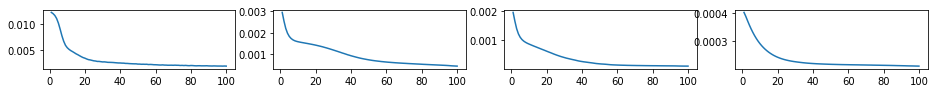

In [7]:
plt.clf()

tot = len(histories)
cols = 5
rows = tot//cols
rows += tot%cols

pos = range(1,tot+1)
print(tot)
fig = plt.figure(1, )
fig.set_figheight(5)
fig.set_figwidth(20)

for i,h in enumerate(histories):
    ax = fig.add_subplot(rows,cols,pos[i])
    loss = h.history['loss']
    epochs = range(1, len(loss)+1)
    ax.plot(epochs, loss)

plt.show()

In [8]:
history = autoencoder.fit(x_train, x_train, batch_size=256, epochs=500, validation_data=(x_val, x_val))

Train on 14737 samples, validate on 1000 samples
Epoch 1/500
14737/14737 [==============================] - 0s 32us/step - loss: 0.0121 - val_loss: 0.0115
Epoch 2/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0118 - val_loss: 0.0110
Epoch 3/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0108 - val_loss: 0.0096
Epoch 4/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0088 - val_loss: 0.0078
Epoch 5/500
14737/14737 [==============================] - 0s 22us/step - loss: 0.0072 - val_loss: 0.0065
Epoch 6/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0059 - val_loss: 0.0057
Epoch 7/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0056 - val_loss: 0.0056
Epoch 8/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0055 - val_loss: 0.0056
Epoch 9/500
14737/14737 [==============================] - 0s 22us/step - loss: 0.0055 - val_loss: 0.00

14737/14737 [==============================] - 0s 23us/step - loss: 0.0037 - val_loss: 0.0038
Epoch 78/500
14737/14737 [==============================] - 0s 22us/step - loss: 0.0037 - val_loss: 0.0038
Epoch 79/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0037 - val_loss: 0.0038
Epoch 80/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0037 - val_loss: 0.0037
Epoch 81/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0037 - val_loss: 0.0037
Epoch 82/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0037 - val_loss: 0.0037
Epoch 83/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0037 - val_loss: 0.0037
Epoch 84/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0037 - val_loss: 0.0037
Epoch 85/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0037 - val_loss: 0.0037
Epoch 86/500
14737/14737 [========================

14737/14737 [==============================] - 0s 23us/step - loss: 0.0031 - val_loss: 0.0031
Epoch 154/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0031 - val_loss: 0.0031
Epoch 155/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0031 - val_loss: 0.0031
Epoch 156/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0031 - val_loss: 0.0031
Epoch 157/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0031 - val_loss: 0.0031
Epoch 158/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0031 - val_loss: 0.0031
Epoch 159/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0031 - val_loss: 0.0031
Epoch 160/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0031 - val_loss: 0.0031
Epoch 161/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0031 - val_loss: 0.0031
Epoch 162/500
14737/14737 [===============

Epoch 229/500
14737/14737 [==============================] - 0s 22us/step - loss: 0.0028 - val_loss: 0.0029
Epoch 230/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0028 - val_loss: 0.0029
Epoch 231/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0028 - val_loss: 0.0029
Epoch 232/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0028 - val_loss: 0.0029
Epoch 233/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0028 - val_loss: 0.0028
Epoch 234/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0028 - val_loss: 0.0028
Epoch 235/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0028 - val_loss: 0.0028
Epoch 236/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0028 - val_loss: 0.0028
Epoch 237/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0028 - val_loss: 0.0028
Epoch 238/500
14737/14737 [=

Epoch 305/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0026 - val_loss: 0.0027
Epoch 306/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0026 - val_loss: 0.0027
Epoch 307/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0026 - val_loss: 0.0027
Epoch 308/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0026 - val_loss: 0.0027
Epoch 309/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0025 - val_loss: 0.0026
Epoch 310/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0025 - val_loss: 0.0027
Epoch 311/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0025 - val_loss: 0.0026
Epoch 312/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0025 - val_loss: 0.0026
Epoch 313/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0025 - val_loss: 0.0026
Epoch 314/500
14737/14737 [=

Epoch 381/500
14737/14737 [==============================] - 0s 24us/step - loss: 0.0024 - val_loss: 0.0025
Epoch 382/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0024 - val_loss: 0.0025
Epoch 383/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0024 - val_loss: 0.0025
Epoch 384/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0024 - val_loss: 0.0025
Epoch 385/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0024 - val_loss: 0.0025
Epoch 386/500
14737/14737 [==============================] - 0s 24us/step - loss: 0.0024 - val_loss: 0.0025
Epoch 387/500
14737/14737 [==============================] - 0s 22us/step - loss: 0.0024 - val_loss: 0.0025
Epoch 388/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0024 - val_loss: 0.0025
Epoch 389/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0024 - val_loss: 0.0025
Epoch 390/500
14737/14737 [=

Epoch 457/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0023 - val_loss: 0.0025
Epoch 458/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0023 - val_loss: 0.0025
Epoch 459/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0023 - val_loss: 0.0025
Epoch 460/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0023 - val_loss: 0.0024
Epoch 461/500
14737/14737 [==============================] - 0s 22us/step - loss: 0.0023 - val_loss: 0.0024
Epoch 462/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0023 - val_loss: 0.0024
Epoch 463/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0023 - val_loss: 0.0024
Epoch 464/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0023 - val_loss: 0.0024
Epoch 465/500
14737/14737 [==============================] - 0s 23us/step - loss: 0.0023 - val_loss: 0.0024
Epoch 466/500
14737/14737 [=

In [8]:
autoencoder.save_weights('autoencoder.h5')

In [9]:
autoencoder.load_weights('autoencoder.h5')

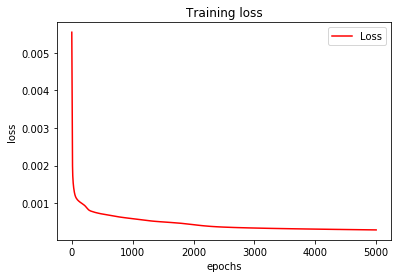

In [9]:
plt.clf()
loss = history.history['loss']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'r', label='Loss')
plt.title('Training loss')
plt.xlabel('epochs')
plt.ylabel('loss')

plt.legend()
plt.show()

In [11]:
for i,layer in enumerate(encoder.layers):
    layer.set_weights(autoencoder.layers[i].get_weights())

In [12]:
class ClusteringLayer(Layer): 
    
    def __init__(self, output_dim, input_dim=None, weights=None, alpha=1.0, **kwargs):
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.alpha = alpha        
        self.initial_weights = weights
        self.input_spec = [InputSpec(ndim=2)]
        
        if self.input_dim:
            kwargs['input_shape'] = (self.input_dim,)
        super(ClusteringLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = [InputSpec(dtype=K.floatx(),
                                     shape=(None, input_dim))]
        self.W = K.variable(self.initial_weights)
        self.trainable_weights = [self.W]
        
    def call(self, x, mask=None):
        q = 1.0/(1.0 + K.sqrt(K.sum(K.square(K.expand_dims(x, 1) - self.W), axis=2))**2/self.alpha)
        q = q**((self.alpha+1.0)/2.0)
        q = K.transpose(K.transpose(q)/K.sum(q, axis=1))
        return q
    
    def get_output_shape_for(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return (input_shape[0], self.output_dim)
    
    def get_output_shape(self, input_shape):
        return self.get_output_shape(input_shape)
    
    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.output_dim
    
    def get_config(self):
        config = {'output_dim': self.output_dim,
                  'input_dim': self.input_dim}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items() + list(config.items)))
    

In [13]:
from sklearn.cluster import KMeans

cluster_centers = None
y_prediction = 0
n_clusters=3
# initialize cluster centres using k-means
print('Initializing cluster centres with k-means.')
if cluster_centers is None:
    kmeans = KMeans(n_clusters=n_clusters, n_init=20)
    y_prediction = kmeans.fit_predict(encoder.predict(x_train))
    cluster_centers = kmeans.cluster_centers_


Initializing cluster centres with k-means.


In [14]:
dec = Sequential([encoder,
                    ClusteringLayer(n_clusters,
                                    weights=cluster_centers,
                                    name='clustering')])

dec.compile(optimizer='adadelta',
              loss='kullback_leibler_divergence')

dec.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 10)                1318010   
_________________________________________________________________
clustering (ClusteringLayer) (None, 3)                 30        
Total params: 1,318,040
Trainable params: 1,318,040
Non-trainable params: 0
_________________________________________________________________


In [15]:
def p_mat(q):
    weight = q**2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

labels = {"av_training_set_AFP": 0,
          "av_training_set_NTP":1,
          "av_training_set_PC":2}

def cluster_acc(y_truth, y_pred):
    yidx = y_truth.idxmax(1).values
    y_true = np.vectorize(labels.get)(yidx)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max())+1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind])*1.0/y_pred.size, w

In [16]:
batch_size = 512
y = y_train
update_interval = 10
iteration = 0
index = 0
train_dec_epochs = 200
master_acc = []
save_interval = x_train.shape[0]/batch_size*50
print(update_interval)
# training loop
for i in range(train_dec_epochs):

    if iteration % update_interval == 0:
        q = dec.predict(x_train, verbose=0)
        p = p_mat(q)
        y_pred = q.argmax(1)
        delta_label = ((y_pred != y_prediction).sum().astype(np.float32) / y_pred.shape[0])
        if y is not None:
            acc = cluster_acc(y, y_prediction)[0]
            master_acc.append(acc)
            print('Iteration '+str(i)+', Accuracy '+str(np.round(acc, 5)))
        else:
            print(str(np.round(delta_label*100, 5))+'%change in label assignment')
        print(str(np.round(delta_label*100, 5))+'%change in label assignment\n')            
        
        y_prediction = y_pred
        
    for i, layer in enumerate(encoder.layers):
        layer.set_weights(dec.layers[0].layers[i].get_weights())
    cluster_centers = dec.layers[-1].get_weights()[0]
    
    # cross validation
    if(index+1)*batch_size > x_train.shape[0]:
        loss = dec.train_on_batch(x_train[index*batch_size::], p[index*batch_size::],
                                    p[index*batch_size::])
        index = 0
    else:
        loss = dec.train_on_batch(x_train[index*batch_size:(index+1) * batch_size],
                                    p[index*batch_size:(index+1) * batch_size])
        index += 1
    iteration +=1

10
Iteration 0, Accuracy 0.52616
0.0%change in label assignment

Iteration 10, Accuracy 0.52616
0.68535%change in label assignment

Iteration 20, Accuracy 0.5267
1.24856%change in label assignment

Iteration 30, Accuracy 0.52657
0.86178%change in label assignment

Iteration 40, Accuracy 0.52602
0.74642%change in label assignment

Iteration 50, Accuracy 0.52344
0.9432%change in label assignment

Iteration 60, Accuracy 0.51856
0.35285%change in label assignment

Iteration 70, Accuracy 0.51659
0.65142%change in label assignment

Iteration 80, Accuracy 0.51863
0.59714%change in label assignment

Iteration 90, Accuracy 0.51727
1.02463%change in label assignment

Iteration 100, Accuracy 0.52053
0.59035%change in label assignment

Iteration 110, Accuracy 0.51591
0.21714%change in label assignment

Iteration 120, Accuracy 0.5151
0.095%change in label assignment

Iteration 130, Accuracy 0.51571
0.11536%change in label assignment

Iteration 140, Accuracy 0.51517
0.35285%change in label assignmen

In [17]:
# add the predicted class to the training set
dec_prediction = dec.predict(x_train, verbose=0)
dec_prediction_val = dec.predict(x_val, verbose=0)

In [17]:
confusion_matrix(y_train.values.argmax(1), dec_prediction.argmax(1))

array([[1982,  917, 6033],
       [ 687,  260, 1453],
       [1466,    6, 1933]])

In [18]:
# we will append all three cluster assignment probs[]
x_train['dec_pred_AFP'] = dec_prediction[:,0]
x_train['dec_pred_NTP'] = dec_prediction[:,1]
x_train['dec_pred_PC'] = dec_prediction[:,2]

x_val['dec_pred_AFP'] = dec_prediction_val[:,0]
x_val['dec_pred_NTP'] = dec_prediction_val[:,1]
x_val['dec_pred_PC'] = dec_prediction_val[:,2]

In [32]:
# use a basic feed forward neural net to classify
# be really dumb and just attempt to pass into a net
classifier = models.Sequential()
classifier.add(layers.Dense(1,kernel_initializer='glorot_uniform',
                       kernel_regularizer=regularizers.l2(0.01),
                       activation='relu', 
                       input_shape=(x_train.shape[1],)))
classifier.add(layers.Dense(3, activation='softmax'))


classifier.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

classifier.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 1)                 91        
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 6         
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


In [33]:
history = classifier.fit(x_train,
                    y_train.values,
                    epochs=100,
                    batch_size=256,
                    validation_data=(x_val, y_val.values))

Train on 14737 samples, validate on 1000 samples
Epoch 1/100
14737/14737 [==============================] - 0s 24us/step - loss: 1.0891 - acc: 0.6159 - val_loss: 1.0605 - val_acc: 0.6780
Epoch 2/100
14737/14737 [==============================] - 0s 9us/step - loss: 1.0394 - acc: 0.6836 - val_loss: 1.0136 - val_acc: 0.7080
Epoch 3/100
14737/14737 [==============================] - 0s 10us/step - loss: 0.9979 - acc: 0.6983 - val_loss: 0.9735 - val_acc: 0.7150
Epoch 4/100
14737/14737 [==============================] - 0s 10us/step - loss: 0.9625 - acc: 0.7043 - val_loss: 0.9386 - val_acc: 0.7200
Epoch 5/100
14737/14737 [==============================] - 0s 10us/step - loss: 0.9319 - acc: 0.7078 - val_loss: 0.9079 - val_acc: 0.7250
Epoch 6/100
14737/14737 [==============================] - 0s 10us/step - loss: 0.9057 - acc: 0.7097 - val_loss: 0.8812 - val_acc: 0.7250
Epoch 7/100
14737/14737 [==============================] - 0s 9us/step - loss: 0.8828 - acc: 0.7115 - val_loss: 0.8575 - val

Epoch 60/100
14737/14737 [==============================] - 0s 9us/step - loss: 0.6377 - acc: 0.7511 - val_loss: 0.6248 - val_acc: 0.7690
Epoch 61/100
14737/14737 [==============================] - 0s 10us/step - loss: 0.6366 - acc: 0.7516 - val_loss: 0.6240 - val_acc: 0.7680
Epoch 62/100
14737/14737 [==============================] - 0s 10us/step - loss: 0.6355 - acc: 0.7513 - val_loss: 0.6233 - val_acc: 0.7690
Epoch 63/100
14737/14737 [==============================] - 0s 10us/step - loss: 0.6346 - acc: 0.7516 - val_loss: 0.6222 - val_acc: 0.7700
Epoch 64/100
14737/14737 [==============================] - 0s 10us/step - loss: 0.6335 - acc: 0.7523 - val_loss: 0.6215 - val_acc: 0.7690
Epoch 65/100
14737/14737 [==============================] - 0s 10us/step - loss: 0.6325 - acc: 0.7520 - val_loss: 0.6206 - val_acc: 0.7690
Epoch 66/100
14737/14737 [==============================] - 0s 10us/step - loss: 0.6316 - acc: 0.7532 - val_loss: 0.6201 - val_acc: 0.7680
Epoch 67/100
14737/14737 [==

In [42]:
weig = classifier.get_weights()
print(max(weig[0]))
print(min(weig[0]))
print()
print(max(weig[1]))
print(min(weig[1]))
print()
print(max(weig[2]))
print(min(weig[2]))


[1.1245707]
[-0.6197936]

0.2871021
0.2871021

[-2.4524834 -5.348136   5.0048842]
[-2.4524834 -5.348136   5.0048842]


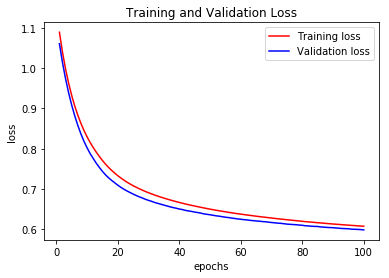

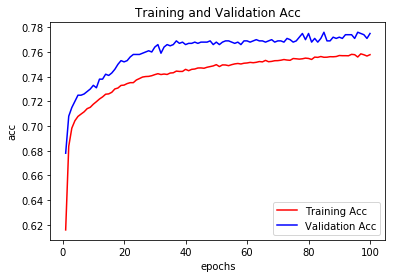

In [34]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) +1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('epochs')
plt.ylabel('loss')

plt.legend()
plt.show()


plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'r', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and Validation Acc')
plt.xlabel('epochs')
plt.ylabel('acc')

plt.legend()
plt.show()

In [22]:
y_train_pred = classifier.predict(x_train)

confusion_matrix(y_train.values.argmax(1), y_train_pred.argmax(1), sample_weight=None)

array([[8409,   28,  495],
       [1853,  502,   45],
       [ 419,    4, 2982]])

In [23]:
y_train

,av_training_set_AFP,av_training_set_NTP,av_training_set_PC
1332,1,0,0
1333,1,0,0
1334,1,0,0
1335,1,0,0
1337,0,1,0
1338,1,0,0
1339,1,0,0
1340,0,0,1
1341,0,0,1
1342,0,0,1


In [20]:
# what happens when we try and train using just the learned features?
# use a basic feed forward neural net to classify
# be really dumb and just attempt to pass into a net
classifier_dec_only = models.Sequential()
classifier_dec_only.add(layers.Dense(50,kernel_initializer='glorot_uniform',
                       kernel_regularizer=regularizers.l2(0.01),
                       activation='relu', 
                       input_shape=(dec_prediction.shape[1],)))
classifier_dec_only.add(layers.Dense(10, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
classifier_dec_only.add(layers.Dense(3, activation='softmax'))


classifier_dec_only.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

classifier_dec_only.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                200       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 33        
Total params: 743
Trainable params: 743
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = classifier_dec_only.fit(dec_prediction,
                    y_train.values,
                    epochs=100,
                    batch_size=512,
                    validation_data=(dec_prediction_val, y_val.values))

Train on 14737 samples, validate on 1000 samples
Epoch 1/100
14737/14737 [==============================] - 0s 18us/step - loss: 1.2009 - acc: 0.6053 - val_loss: 1.1166 - val_acc: 0.6640
Epoch 2/100
14737/14737 [==============================] - 0s 5us/step - loss: 1.1052 - acc: 0.6061 - val_loss: 1.0293 - val_acc: 0.6640
Epoch 3/100
14737/14737 [==============================] - 0s 5us/step - loss: 1.0482 - acc: 0.6061 - val_loss: 0.9745 - val_acc: 0.6640
Epoch 4/100
14737/14737 [==============================] - 0s 5us/step - loss: 1.0147 - acc: 0.6061 - val_loss: 0.9445 - val_acc: 0.6640
Epoch 5/100
14737/14737 [==============================] - 0s 5us/step - loss: 0.9898 - acc: 0.6061 - val_loss: 0.9254 - val_acc: 0.6640
Epoch 6/100
14737/14737 [==============================] - 0s 5us/step - loss: 0.9719 - acc: 0.6061 - val_loss: 0.9098 - val_acc: 0.6640
Epoch 7/100
14737/14737 [==============================] - 0s 6us/step - loss: 0.9592 - acc: 0.6061 - val_loss: 0.8971 - val_acc

14737/14737 [==============================] - 0s 6us/step - loss: 0.9241 - acc: 0.6061 - val_loss: 0.8647 - val_acc: 0.6640
Epoch 61/100
14737/14737 [==============================] - 0s 5us/step - loss: 0.9244 - acc: 0.6061 - val_loss: 0.8696 - val_acc: 0.6640
Epoch 62/100
14737/14737 [==============================] - 0s 5us/step - loss: 0.9244 - acc: 0.6061 - val_loss: 0.8723 - val_acc: 0.6640
Epoch 63/100
14737/14737 [==============================] - 0s 6us/step - loss: 0.9240 - acc: 0.6061 - val_loss: 0.8728 - val_acc: 0.6640
Epoch 64/100
14737/14737 [==============================] - 0s 5us/step - loss: 0.9240 - acc: 0.6061 - val_loss: 0.8680 - val_acc: 0.6640
Epoch 65/100
14737/14737 [==============================] - 0s 6us/step - loss: 0.9241 - acc: 0.6061 - val_loss: 0.8717 - val_acc: 0.6640
Epoch 66/100
14737/14737 [==============================] - 0s 6us/step - loss: 0.9240 - acc: 0.6061 - val_loss: 0.8679 - val_acc: 0.6640
Epoch 67/100
14737/14737 [=====================

In [31]:
pd.options.display.max_columns = None

x_train


,tce_period,tce_period_err,tce_time0bk,tce_time0bk_err,tce_time0,tce_time0_err,tce_ror,tce_ror_err,tce_dor,tce_dor_err,tce_incl,tce_incl_err,tce_impact,tce_impact_err,tce_duration,tce_duration_err,tce_ingress,tce_ingress_err,tce_depth,tce_depth_err,tce_ldm_coeff1,tce_ldm_coeff2,tce_ldm_coeff3,tce_ldm_coeff4,tce_num_transits,tce_full_conv,tce_model_snr,tce_model_chisq,tce_model_dof,tce_robstat,tce_dof1,tce_dof2,tce_chisq1,tce_chisq2,tce_prad,tce_prad_err,tce_sma,tce_sma_err,tce_eqt,tce_eqt_err,tce_nkoi,tce_quarters,tce_steff,tce_steff_err,tce_slogg,tce_slogg_err,tce_smet,tce_smet_err,tce_sradius,tce_sradius_err,tce_mesmad,tce_maxmes,tce_minmes,tce_maxmesd,tce_minmesd,tce_max_sngle_ev,tce_max_mult_ev,tce_bin_oedp_stat,tce_rmesmad,tce_rsnrmes,tce_rminmes,boot_fap,boot_mesthresh,boot_mesmean,boot_messtd,tce_fwm_stat,tce_fwm_sra,tce_fwm_sra_err,tce_fwm_sdec,tce_fwm_sdec_err,tce_fwm_srao,tce_fwm_srao_err,tce_fwm_sdeco,tce_fwm_sdeco_err,tce_fwm_prao,tce_fwm_prao_err,tce_fwm_pdeco,tce_fwm_pdeco_err,tce_dicco_mra,tce_dicco_mra_err,tce_dicco_mdec,tce_dicco_mdec_err,tce_dicco_msky,tce_dicco_msky_err,tce_dikco_mra,tce_dikco_mra_err,tce_dikco_mdec,tce_dikco_mdec_err,tce_dikco_msky,tce_dikco_msky_err
1332,-0.034910,-0.000116,-0.017535,-0.000092,-0.012877,-0.000092,-0.009379,-0.000206,-0.007861,-0.000068,0.112753,-0.000214,-0.070394,-0.000105,-0.025082,-0.000123,-0.004241,-0.000176,-0.005399,-0.000401,0.035130,-0.037532,0.055836,-0.075418,-0.138831,0.050282,-0.003389,-0.000075,-0.119813,-0.000272,-0.133231,-0.133220,-0.000102,-0.000068,-0.001447,-0.000401,-0.030999,-0.000097,-0.026305,-0.000107,0.038562,0.119111,-0.030943,-0.009184,-0.027135,0.006138,0.074927,-0.039260,-0.002577,-0.001254,-0.002420,-0.000077,0.000088,-0.007675,-0.007900,-0.000085,-0.000081,-0.000090,-0.000123,-0.072809,-0.022552,0.009769,-0.000085,0.000087,-0.000086,0.010829,0.053879,0.080046,-0.041538,0.078145,0.017180,-0.002531,-0.013936,-0.003012,-0.000068,-0.000068,0.000068,-0.000068,0.128933,-0.013586,-0.047258,-0.008048,0.100782,-0.008918,0.096531,-0.007539,-0.041549,-0.006545,0.099425,-0.006095
1333,-0.034910,-0.000116,-0.017537,-0.000092,-0.012877,-0.000092,0.086793,-0.000211,-0.007476,-0.000068,0.128480,-0.000214,-0.217195,-0.000105,-0.008426,-0.000123,0.003713,-0.000177,0.060924,-0.000274,-0.004244,0.004733,0.008624,-0.024046,-0.204975,0.050282,0.022182,-0.000077,-0.174386,0.000120,-0.199575,-0.199558,-0.000102,-0.000068,0.007886,-0.000410,-0.031678,-0.000097,-0.043415,-0.000124,0.038562,-0.880889,-0.023387,-0.000359,0.037875,0.006138,0.031314,-0.012594,-0.004500,-0.002560,-0.001961,-0.000077,0.000088,-0.007719,-0.007072,-0.000085,-0.000081,-0.000090,-0.000104,-0.009171,-0.023616,0.009769,-0.000085,0.000087,-0.000086,0.008202,0.053827,0.080041,-0.041386,0.078067,-0.001567,-0.004069,-0.000001,-0.005791,-0.000068,-0.000068,0.000068,-0.000068,0.000715,-0.078762,-0.000102,-0.046503,-0.015956,-0.043483,0.000805,-0.007563,-0.000882,-0.006390,-0.014483,-0.005961
1334,-0.034910,-0.000116,-0.021386,-0.000092,-0.012877,-0.000092,0.009944,-0.000212,-0.006997,-0.000068,0.145034,-0.000214,-0.434295,-0.000105,-0.031661,-0.000123,-0.003017,-0.000177,-0.002073,-0.000402,-0.004244,0.004733,0.008624,-0.024046,-0.203854,-0.949718,-0.004775,-0.000083,-0.276503,-0.000271,-0.198817,-0.198800,-0.000102,-0.000068,0.000323,-0.000411,-0.031678,-0.000097,-0.043415,-0.000219,0.038562,-0.880889,-0.023387,-0.000359,0.037875,0.006138,0.031314,-0.012594,-0.004500,-0.002560,-0.002088,-0.000077,0.000088,-0.012022,-0.010438,-0.000085,-0.000081,-0.000090,-0.000125,-0.219290,-0.019651,0.009769,-0.000085,0.000087,-0.000086,-0.001152,-0.893024,-0.917267,-0.772428,-0.896688,-0.000002,-0.010744,-0.000096,-0.015416,-0.000068,-0.000068,0.000068,-0.000068,0.000715,-0.078762,-0.000102,-0.046503,-0.015956,-0.043483,0.000574,-0.043372,0.000036,-0.037178,-0.016006,-0.029572
1335,-0.034755,-0.000116,-0.020431,-0.000092,-0.012877,-0.000092,-0.009806,-0.000202,-0.006327,-0.000068,0.135929,-0.000214,-0.235995,-0.000